In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats

DIR = "/home/julian/Documents/ndnrtc_testing/evaluation/reTrans_evaluation_results"

# read in csv file
df = pd.read_csv(DIR + '/run_overview.csv', delimiter='\t', index_col=False)

# transform columns names to lower case
df.columns = [col.lower() for col in df]

# ensuring backwards compatibility
df.rename(columns={"adaption":"init._res."}, inplace=True)

# ensuring forwards compatibility
df.rename(columns={"retr._total":"retransmissions", 
                   "al_seq.len.":"al_seq_len"}, inplace=True)

#df.head(10)

In [2]:
def customFilter (df, al_w1_fixed, al_w2_fixed, al_th1_fixed, al_th2_fixed, al_seq_len_fixed):
   
    # filter data according to fixed parameters
    df_tmp = df[(df.al_w1 == al_w1_fixed) 
             & (df.al_w2 == al_w2_fixed)
             & (df.al_th1 == al_th1_fixed) 
             & (df.al_th2 == al_th2_fixed)
             & (df.al_seq_len == al_seq_len_fixed)]
    
    return df_tmp
 
def calculateGroupedMeans (df, data, metric):
    for setting in df["setting"].unique():
       
        # get first row as series for parameters
        df_row = df[df.setting == setting].iloc[0]
    
        # get all rows with those parameters for calculations
        tmp = customFilter(df, df_row.al_w1, df_row.al_w2, df_row.al_th1, df_row.al_th2, df_row.al_seq_len)
    
        # convert the parameter columns to a 1-line DataFrame
        df_row = pd.DataFrame(df_row).T
    
        # calculate and concatenate mean values as new columns
        df_row_c = df_row[df_row.columns[6:11]].assign(metric_mean_HL=tmp[tmp.shaping_profile=="HL"].mean()[metric], 
                                                       metric_mean_LH=tmp[tmp.shaping_profile=="LH"].mean()[metric],
                                                       metric_mean_HLH=tmp[tmp.shaping_profile=="HLH"].mean()[metric],
                                                       metric_mean_LHL=tmp[tmp.shaping_profile=="LHL"].mean()[metric],
                                                       metric_mean=tmp.mean()[metric],
                                                       metric_std_HL=tmp[tmp.shaping_profile=="HL"].std()[metric], 
                                                       metric_std_LH=tmp[tmp.shaping_profile=="LH"].std()[metric],
                                                       metric_std_HLH=tmp[tmp.shaping_profile=="HLH"].std()[metric],
                                                       metric_std_LHL=tmp[tmp.shaping_profile=="LHL"].std()[metric],
                                                       metric_std=tmp.std()[metric])

        # collect 1-line DataFrames in bigger DataFrame
        data = data.append(df_row_c)
        
    # rename columns according to metric name    
    data.rename(columns={"metric_mean" : metric + "_mean",
                        "metric_mean_HL" : metric + "_mean_HL",
                        "metric_mean_LH" : metric + "_mean_LH",
                        "metric_mean_HLH" : metric + "_mean_HLH",
                        "metric_mean_LHL" : metric + "_mean_LHL",
                        "metric_std" : metric + "_std",
                        "metric_std_HL" : metric + "_std_HL",
                        "metric_std_LH" : metric + "_std_LH",
                        "metric_std_HLH" : metric + "_std_HLH",
                        "metric_std_LHL" : metric + "_std_LHL"}, inplace=True)
    return data.drop_duplicates()


In [3]:
def prepareDataforPerformanceComparisonBarPlot(metric):
    
    # calclulate mean and std dev values for all shaping patterns + total avg
    # (ignore all rows in Dataframe beyond setting 300 (not relevant for this))
    data = pd.DataFrame()
    data = calculateGroupedMeans(df[df.setting <= 300], data, metric)
    
    # sort values in order and only keep top x entries (usually 5)
    asc = False
    if metric == "retransmissions" or metric == "frames_missing":
        asc = True
    data_top5 = data.sort_values(metric + "_mean", ascending=asc).head(5)
    
    # reset index for new DataFrame
    data_top5.reset_index(drop=True, inplace=True)
    
    return data_top5

In [10]:
def drawPerformanceComparisonBarPlot(metric):
    
    # get data for plot
    data_top5 = prepareDataforPerformanceComparisonBarPlot(metric)
    
    # prepare some variables & parameters for plotting
    fig, ax = plt.subplots()
    positions = np.array([0,6,12,18,24])
    group_colors=["royalblue", "palegreen", "springgreen", "mediumseagreen", "seagreen"]
    topx = len(data_top5.index)
    xlabels = ["weights\nthresholds\nsequence length"]
    
    # draw bars for each of the groups
    for x in range(0,topx):
        
        # prepare some additional parameters
        pos = positions + x
        values = data_top5[data_top5.columns[topx+x]]
        errors = data_top5[data_top5.columns[2*topx+x]]
        label = data_top5.columns[5+x].split("_")[-1]
        color = group_colors[x]
        
        # draw bar with error markers
        rect = ax.bar(pos, values, width=1, yerr=errors, label=label, color=color, edgecolor="black", capsize=3)
        
        # prepare labels for each group of bars
        xlabels.append(str(data_top5.al_w1[x]) +  " | " + str(data_top5.al_w2[x]) + "\n" + 
                    str(data_top5.al_th1[x]) + " | " + str(data_top5.al_th2[x]) + "\n" + 
                    str(data_top5.al_seq_len[x]) + "\n")
        
    #some adjustments for better readability
    if metric == "psnr":
        ax.set_ylim(0, 30) # 20
    if metric == "ssim":
        ax.set_ylim(0.3, 0.9) # 0.7
    if metric == "vmaf":
        ax.set_ylim(30, 51) 
    if metric == "retransmissions":
        ax.set_ylim(0, 1000)    
    if metric == "frames_missing":
        ax.set_ylim(0, 900)
    
    # add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric)
    ax.set_title('Performance Comparison of Top 5 Settings')
    ax.set_xticks([-5,2,8,14,20,26])
    ax.set_xticklabels(xlabels)
    ax.legend()
    plt.tight_layout()
    
    # save created plot as a pdf
    plt.savefig(DIR + "/reTrans_shapingProfile_" + metric + "_comparison" + ".pdf")
    
def drawPerformanceComparisonBarPlots():
    drawPerformanceComparisonBarPlot("psnr")
    drawPerformanceComparisonBarPlot("ssim")
    drawPerformanceComparisonBarPlot("vmaf")
    drawPerformanceComparisonBarPlot("retransmissions")
    drawPerformanceComparisonBarPlot("frames_missing")
    

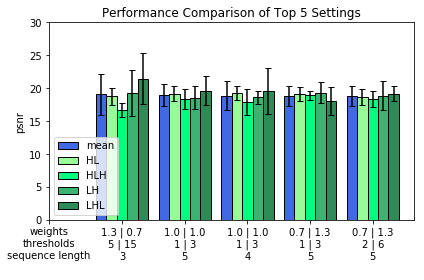

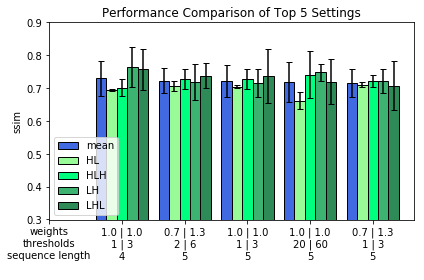

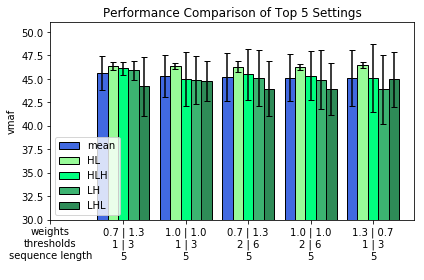

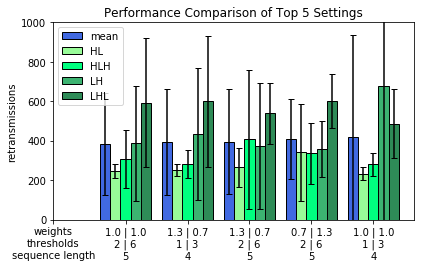

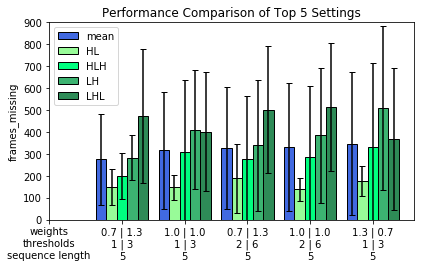

In [11]:
drawPerformanceComparisonBarPlots()